# Exercise 2: Neural Networks

In the previous exercise you implemented a binary classifier with one linear layer on a small portion of CIFAR-10. In this exercise, you will implement a three layer multi-class neural network.

## Submission guidelines:

Your submission should include a zip archive (not RAR or any other form of compression) that includes this jupyter notebook with a name of ex2_ID.ipynb and the solution to the theoretical component in pdf format with the name ex2_ID.pdf. The zip archive itself should be named ex2_ID.zip.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. **Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. Code that cannot run will not be tested.**
8. Write your own code. Cheating will not be tolerated. 
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [2]:
def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Limit it because rounding errors may cause it to exceed 100%.
    pct_complete = min(1.0, pct_complete)

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

def download(base_url, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    filename = base_url.split("/")[-1]
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=base_url,
                                                  filename=save_path,
                                                  reporthook=_print_download_progress)

        print(" Done!")

def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.


## Data Preprocessing

**Notice that we are leaving behind the bias trick in this exercise.**

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data

# define a splitting for the data
num_training = 49000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Shape of test set: {X_test.shape}")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Shape of training set: (49000, 3072)
Shape of validation set: (1000, 3072)
Shape of test set: (1000, 3072)


      cat       car       cat      frog


<ipython-input-5-7022e0683537>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))


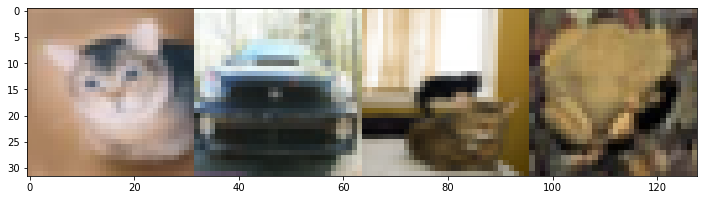

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
      rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
      rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
      grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images]))
    else:
      grid = np.hstack(np.array([np.asarray(i, dtype=np.int) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x, (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True));

# Loss

## Cross-entropy


Complete the function `softmax_loss` using vectorized code. This function takes as input the data `X`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to X. **(10 Points)**

In [6]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    ###########################################################################
    # TODO: Implement this function                                           #
    ###########################################################################
    
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y]))
    
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    
    loss = loss / N
    dx = dx / N

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return loss, dx

## L2 Regularization

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. 
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$

Implement the L2 regularization part of the loss in the next cell: **(10 Points)**

In [7]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    #############################################################################
    # TODO: Compute the L2 regularization loss and its gradient using no
    # explicit loops.                                                           #
    # Store the loss in loss and the gradient in dW.                            #
    #############################################################################

    loss = reg * 0.5 * np.sum(W * W)
    dW = reg * W
    
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

# Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass. The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass. The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights. By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

We will implement a neural network to obtain better results on CIFAR-10. If you were careful, you should have got a classification accuracy of over 38% on the test set using a simple single layer network. However, using multiple layers we could reach around 50% accuracy. Our neural network will be implemented in the following cells. We will train this network using softmax loss and L2 regularization and a ReLU non-linearity after the first two fully connected layers.



### Fully Connected Layer: Forward Pass. 

Implement the function `fc_forward`. **(5 Points)**

In [8]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################

    N = X.shape[0]
    D = np.prod(X.shape[1:])
    X_reshaped = X.reshape(N, D)
    out = np.dot(X_reshaped, W) + b

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [9]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### Fully Connected Layer: Backward Pass 

Implement the function `fc_backward` **(5 Points)**

In [10]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    
    N = x.shape[0]
    D = np.prod(x.shape[1:])
    X_reshaped = x.reshape(N, D)

    dw = X_reshaped.T.dot(dout)
    dx = dout.dot(w.T).reshape(x.shape)
    db = np.sum(dout, axis=0)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


In [11]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
      ix = it.multi_index

      oldval = x[ix]
      x[ix] = oldval + h
      pos = f(x).copy()
      x[ix] = oldval - h
      neg = f(x).copy()
      x[ix] = oldval

      grad[ix] = np.sum((pos - neg) * df) / (2 * h)
      it.iternext()
    return grad

In [12]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

### ReLU: Forward Pass 

Implement the function `relu_forward`. **(5 Points)**

In [13]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################

    out = np.maximum(0, x)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x.copy()
    return out, cache

In [14]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### ReLU: Backward Pass

Implement the function `relu_backward`. **(5 Points)**

In [15]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################

    out = np.maximum(0, x)
    out[out > 0] = 1
    dx = out * dout
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

In [16]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

### Combined Layer
Next combine the fully connected and relu forward\backward functions togther using the functions in the following cell: **(5 Points)**

In [17]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    fc_out, fc_cache = fc_forward(X, W, b)
    out, relu_cache = relu_forward(fc_out)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    drelu = relu_backward(dout, relu_cache)
    dx, dw, db = fc_backward(drelu, fc_cache)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

You can check your results in the next cell:

In [18]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

# Building the Network



Complete the class `ThreeLayerNet`. **(35 Points)**

In [19]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first two fully
    connected layers. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax

    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        
        layer1_out, layer1_cache = fc_relu_forward(X, W1, b1)
        layer2_out, layer2_cache = fc_relu_forward(layer1_out, W2, b2)
        scores, fc_cache = fc_forward(layer2_out, W3, b3)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
          return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1, W2, W3. Store the result #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss. We provided a version of softmax_loss at the             #
        # end of the file. it takes the scores and labels and computes the loss and #
        # derivatives for you.                                                      #         
        #############################################################################
        
        loss, dscores = softmax_loss(scores, y)
        W1_loss, dW1 = l2_regulariztion_loss(W1, reg)
        W2_loss, dW2 = l2_regulariztion_loss(W2, reg)
        W3_loss, dW3 = l2_regulariztion_loss(W3, reg)
        
        loss = loss + W1_loss + W2_loss + W3_loss

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        
        dx3, dW3, db3 = fc_backward(dscores, fc_cache)
        dx2, dW2, db2 = fc_relu_backward(dx3, layer2_cache)
        dx1, dW1, db1 = fc_relu_backward(dx2, layer1_cache)
        
        grads['W3'] = dW3 + reg * W3
        grads['b3'] = db3

        grads['W2'] = dW2 + reg * W2
        grads['b2'] = db2

        grads['W1'] = dW1 + reg * W1
        grads['b1'] = db1

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
          X_batch = None
          y_batch = None
          #########################################################################
          # TODO: Create a random minibatch of training data and labels, storing  #
          # them in X_batch and y_batch respectively.                             #
          #########################################################################

          batch = np.random.choice(num_train, batch_size, replace = True)
          X_batch = X[batch]
          y_batch = y[batch]
            
          #########################################################################
          #                             END OF YOUR CODE                          #
          #########################################################################

          # Compute loss and gradients using the current minibatch
          loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
          loss_history.append(loss)
          #########################################################################
          # TODO: Use the gradients in the grads dictionary to update the         #
          # parameters of the network (stored in the dictionary self.params)      #
          # using stochastic gradient descent. You'll need to use the gradients   #
          # stored in the grads dictionary defined above.                         #
          #########################################################################

          self.params['W3'] -= learning_rate * grads['W3']
          self.params['b3'] -= learning_rate * grads['b3']
          self.params['W2'] -= learning_rate * grads['W2']
          self.params['b2'] -= learning_rate * grads['b2']
          self.params['W1'] -= learning_rate * grads['W1']
          self.params['b1'] -= learning_rate * grads['b1']  
            
          #########################################################################
          #                             END OF YOUR CODE                          #
          #########################################################################

          if verbose and it % 100 == 0:
            print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

          # Every epoch, check train and val accuracy.
          if it % iterations_per_epoch == 0:
            train_acc = (self.predict(X_batch) == y_batch).mean()
            val_acc = (self.predict(X_val) == y_val).mean()
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        ###########################################################################
        # TODO: Implement this function                                           #
        ###########################################################################

        layer1_out = np.maximum(0, X.dot(W1)) + b1
        layer2_out = np.maximum(0, layer1_out.dot(W2)) + b2
        out = np.dot(layer2_out, W3) + b3

        p = np.exp(out - np.max(out, axis=1, keepdims=True))
        p = p / np.sum(p, axis=1, keepdims=True)

        y_pred = np.asarray(np.argmax(p, axis=1)).reshape(-1)
        
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################
        return y_pred

In [20]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [21]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=2500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 0 / 2500: loss 2.311579
iteration 100 / 2500: loss 2.222239
iteration 200 / 2500: loss 2.045468
iteration 300 / 2500: loss 2.061172
iteration 400 / 2500: loss 1.904972
iteration 500 / 2500: loss 1.932608
iteration 600 / 2500: loss 1.829387
iteration 700 / 2500: loss 1.873234
iteration 800 / 2500: loss 1.731084
iteration 900 / 2500: loss 1.756730
iteration 1000 / 2500: loss 1.724184
iteration 1100 / 2500: loss 1.641730
iteration 1200 / 2500: loss 1.649471
iteration 1300 / 2500: loss 1.706341
iteration 1400 / 2500: loss 1.614632
iteration 1500 / 2500: loss 1.659453
iteration 1600 / 2500: loss 1.571183
iteration 1700 / 2500: loss 1.567828
iteration 1800 / 2500: loss 1.660714
iteration 1900 / 2500: loss 1.664497
iteration 2000 / 2500: loss 1.502849
iteration 2100 / 2500: loss 1.443697
iteration 2200 / 2500: loss 1.518325
iteration 2300 / 2500: loss 1.453358
iteration 2400 / 2500: loss 1.618552


In [22]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.451


In [23]:
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.4533673469387755


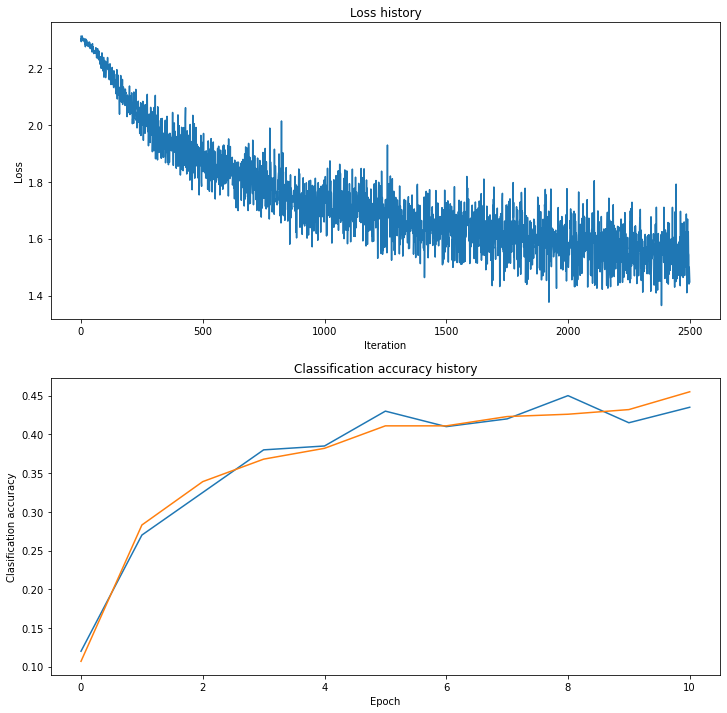

In [24]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

## **Question:**
What can you say about the diffrence (or lack of thereof) between the validation and training accuracy? What can you say about the connection between the loss and the accuracy? **(5 Points)**

**Your answer:** *Overall, the valdiation and training accuracy are similar, which suggest the model manage to generalize and suggest we have low bias and low variance. Also, as we can see from the plots above, we have an inverted connection between the loss and the accuracy. Particularly, when the loss is decreasing, the accuracy is increasing overtime, which is logic since we minimize the loss function and the overall model's performence is improving*

## Hyperparameter Optimization
Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **(10 Points)**

lr: 1e-07, hidden_size: 200, regularization: 0
iteration 0 / 2500: loss 2.391683
iteration 100 / 2500: loss 2.295426
iteration 200 / 2500: loss 2.387531
iteration 300 / 2500: loss 2.355815
iteration 400 / 2500: loss 2.359625
iteration 500 / 2500: loss 2.371928
iteration 600 / 2500: loss 2.384810
iteration 700 / 2500: loss 2.343606
iteration 800 / 2500: loss 2.347481
iteration 900 / 2500: loss 2.315173
iteration 1000 / 2500: loss 2.358290
iteration 1100 / 2500: loss 2.345665
iteration 1200 / 2500: loss 2.344411
iteration 1300 / 2500: loss 2.390453
iteration 1400 / 2500: loss 2.365580
iteration 1500 / 2500: loss 2.395939
iteration 1600 / 2500: loss 2.325319
iteration 1700 / 2500: loss 2.387237
iteration 1800 / 2500: loss 2.380334
iteration 1900 / 2500: loss 2.357489
iteration 2000 / 2500: loss 2.365313
iteration 2100 / 2500: loss 2.356143
iteration 2200 / 2500: loss 2.352934
iteration 2300 / 2500: loss 2.365813
iteration 2400 / 2500: loss 2.371763




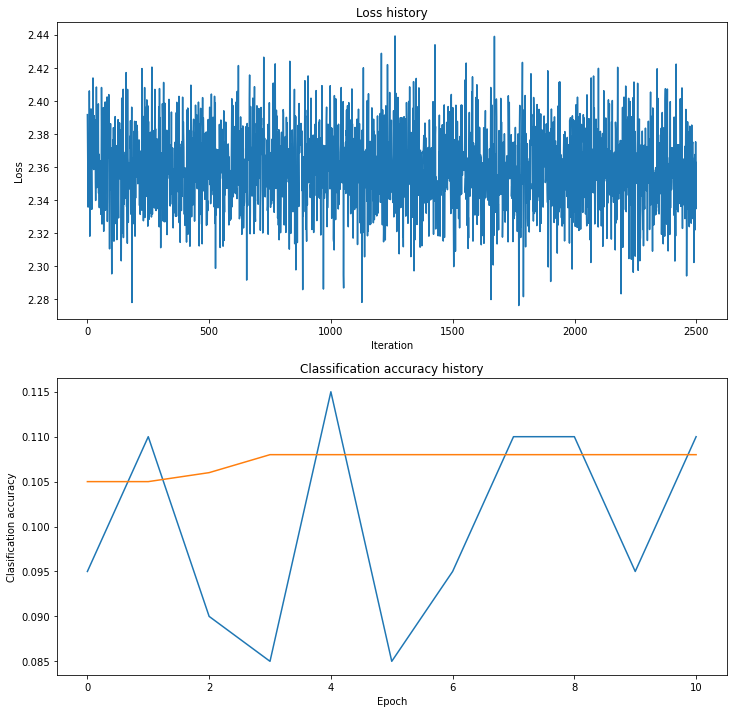

lr: 0.001, hidden_size: 1, regularization: 0
iteration 0 / 2500: loss 2.302557
iteration 100 / 2500: loss 2.302356
iteration 200 / 2500: loss 2.302027
iteration 300 / 2500: loss 2.302460
iteration 400 / 2500: loss 2.300081
iteration 500 / 2500: loss 2.288671
iteration 600 / 2500: loss 2.245299
iteration 700 / 2500: loss 2.176965
iteration 800 / 2500: loss 2.220221
iteration 900 / 2500: loss 2.171842
iteration 1000 / 2500: loss 2.207594
iteration 1100 / 2500: loss 2.150819
iteration 1200 / 2500: loss 2.200446
iteration 1300 / 2500: loss 2.218553
iteration 1400 / 2500: loss 2.175224
iteration 1500 / 2500: loss 2.170994
iteration 1600 / 2500: loss 2.163846
iteration 1700 / 2500: loss 2.129991
iteration 1800 / 2500: loss 2.146826
iteration 1900 / 2500: loss 2.137192
iteration 2000 / 2500: loss 2.206274
iteration 2100 / 2500: loss 2.130816
iteration 2200 / 2500: loss 2.181546
iteration 2300 / 2500: loss 2.130865
iteration 2400 / 2500: loss 2.151882




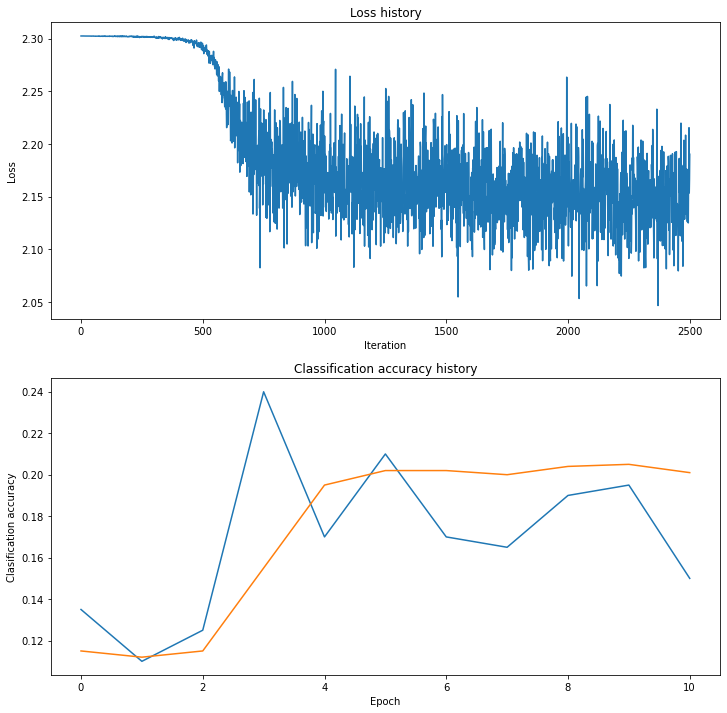

lr: 0.001, hidden_size: 1, regularization: 0.1
iteration 0 / 2500: loss 2.317713
iteration 100 / 2500: loss 2.317332
iteration 200 / 2500: loss 2.317092
iteration 300 / 2500: loss 2.316547
iteration 400 / 2500: loss 2.316259
iteration 500 / 2500: loss 2.316104
iteration 600 / 2500: loss 2.315647
iteration 700 / 2500: loss 2.315539
iteration 800 / 2500: loss 2.313718
iteration 900 / 2500: loss 2.314777
iteration 1000 / 2500: loss 2.306587
iteration 1100 / 2500: loss 2.287227
iteration 1200 / 2500: loss 2.270028
iteration 1300 / 2500: loss 2.247734
iteration 1400 / 2500: loss 2.249221
iteration 1500 / 2500: loss 2.228464
iteration 1600 / 2500: loss 2.243537
iteration 1700 / 2500: loss 2.202019
iteration 1800 / 2500: loss 2.192068
iteration 1900 / 2500: loss 2.211842
iteration 2000 / 2500: loss 2.202903
iteration 2100 / 2500: loss 2.198756
iteration 2200 / 2500: loss 2.208643
iteration 2300 / 2500: loss 2.210735
iteration 2400 / 2500: loss 2.233262




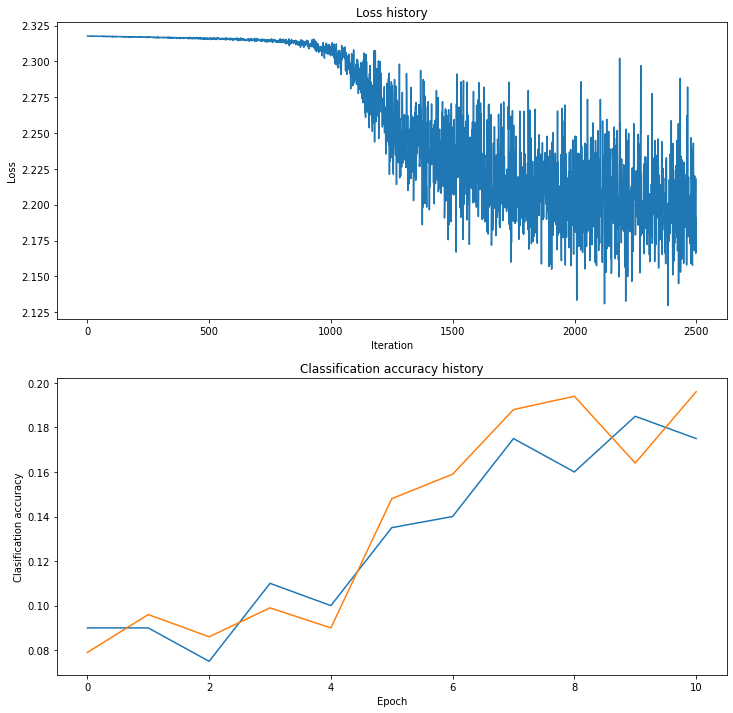

lr: 0.001, hidden_size: 1, regularization: 0.15
iteration 0 / 2500: loss 2.325645
iteration 100 / 2500: loss 2.324961
iteration 200 / 2500: loss 2.324324
iteration 300 / 2500: loss 2.323613
iteration 400 / 2500: loss 2.323071
iteration 500 / 2500: loss 2.322497
iteration 600 / 2500: loss 2.321743
iteration 700 / 2500: loss 2.321303
iteration 800 / 2500: loss 2.320716
iteration 900 / 2500: loss 2.320288
iteration 1000 / 2500: loss 2.319622
iteration 1100 / 2500: loss 2.319193
iteration 1200 / 2500: loss 2.318733
iteration 1300 / 2500: loss 2.318247
iteration 1400 / 2500: loss 2.317681
iteration 1500 / 2500: loss 2.317263
iteration 1600 / 2500: loss 2.316860
iteration 1700 / 2500: loss 2.316497
iteration 1800 / 2500: loss 2.315899
iteration 1900 / 2500: loss 2.315677
iteration 2000 / 2500: loss 2.315360
iteration 2100 / 2500: loss 2.314774
iteration 2200 / 2500: loss 2.314497
iteration 2300 / 2500: loss 2.314083
iteration 2400 / 2500: loss 2.313758




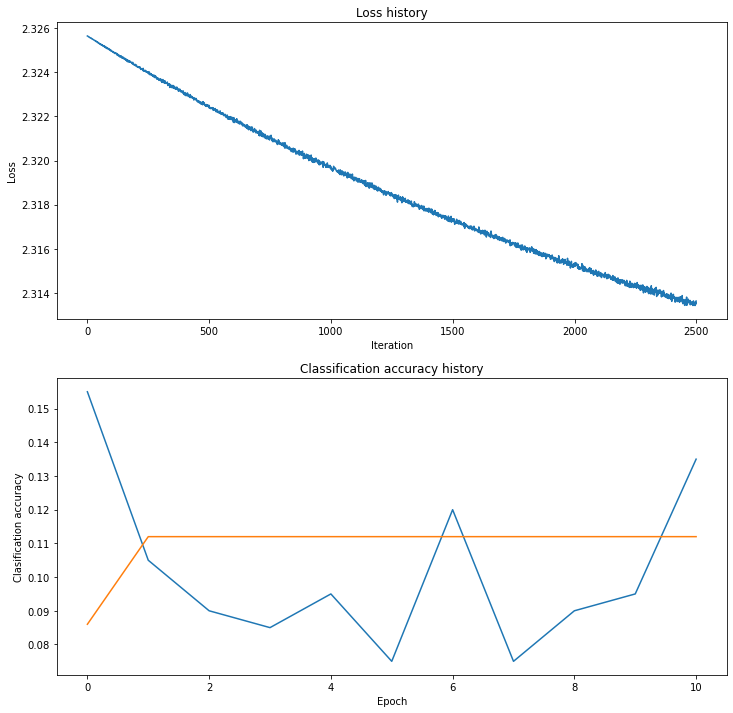

lr: 0.001, hidden_size: 1, regularization: 0.2
iteration 0 / 2500: loss 2.333508
iteration 100 / 2500: loss 2.332289
iteration 200 / 2500: loss 2.331141
iteration 300 / 2500: loss 2.330025
iteration 400 / 2500: loss 2.328962
iteration 500 / 2500: loss 2.327870
iteration 600 / 2500: loss 2.326907
iteration 700 / 2500: loss 2.325949
iteration 800 / 2500: loss 2.325055
iteration 900 / 2500: loss 2.324149
iteration 1000 / 2500: loss 2.323299
iteration 1100 / 2500: loss 2.322506
iteration 1200 / 2500: loss 2.321747
iteration 1300 / 2500: loss 2.321001
iteration 1400 / 2500: loss 2.320240
iteration 1500 / 2500: loss 2.319554
iteration 1600 / 2500: loss 2.318863
iteration 1700 / 2500: loss 2.318273
iteration 1800 / 2500: loss 2.317620
iteration 1900 / 2500: loss 2.317178
iteration 2000 / 2500: loss 2.316544
iteration 2100 / 2500: loss 2.315919
iteration 2200 / 2500: loss 2.315409
iteration 2300 / 2500: loss 2.314870
iteration 2400 / 2500: loss 2.314408




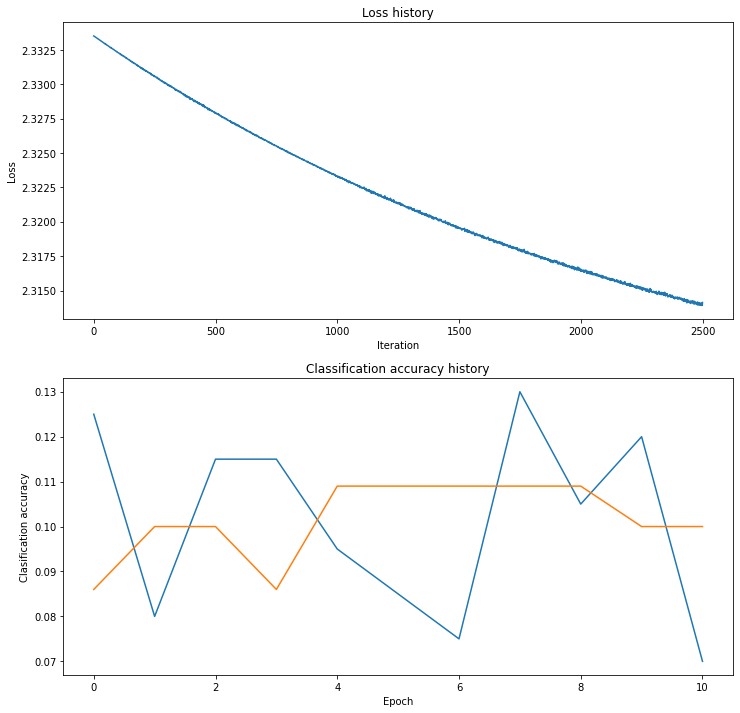

lr: 0.001, hidden_size: 1, regularization: 0.25
iteration 0 / 2500: loss 2.341848
iteration 100 / 2500: loss 2.339937
iteration 200 / 2500: loss 2.338123
iteration 300 / 2500: loss 2.336357
iteration 400 / 2500: loss 2.334697
iteration 500 / 2500: loss 2.333166
iteration 600 / 2500: loss 2.331667
iteration 700 / 2500: loss 2.330292
iteration 800 / 2500: loss 2.328980
iteration 900 / 2500: loss 2.327662
iteration 1000 / 2500: loss 2.326404
iteration 1100 / 2500: loss 2.325226
iteration 1200 / 2500: loss 2.324150
iteration 1300 / 2500: loss 2.323137
iteration 1400 / 2500: loss 2.322054
iteration 1500 / 2500: loss 2.321044
iteration 1600 / 2500: loss 2.320239
iteration 1700 / 2500: loss 2.319485
iteration 1800 / 2500: loss 2.318486
iteration 1900 / 2500: loss 2.317759
iteration 2000 / 2500: loss 2.317108
iteration 2100 / 2500: loss 2.316379
iteration 2200 / 2500: loss 2.315651
iteration 2300 / 2500: loss 2.315113
iteration 2400 / 2500: loss 2.314374




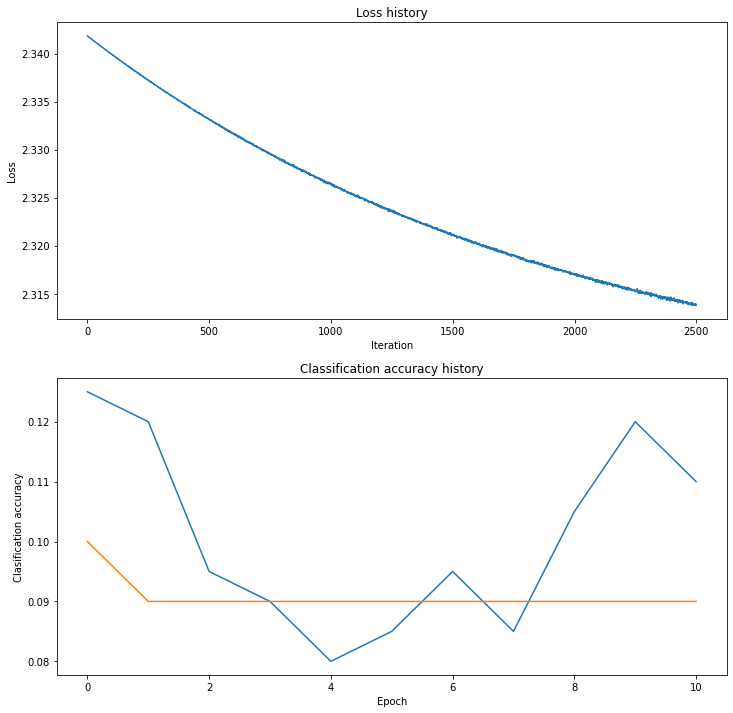

lr: 0.001, hidden_size: 1, regularization: 0.5
iteration 0 / 2500: loss 2.382318
iteration 100 / 2500: loss 2.375056
iteration 200 / 2500: loss 2.367512
iteration 300 / 2500: loss 2.361441
iteration 400 / 2500: loss 2.355004
iteration 500 / 2500: loss 2.350226
iteration 600 / 2500: loss 2.342494
iteration 700 / 2500: loss 2.320237
iteration 800 / 2500: loss 2.302389
iteration 900 / 2500: loss 2.252202
iteration 1000 / 2500: loss 2.260931
iteration 1100 / 2500: loss 2.239641
iteration 1200 / 2500: loss 2.259345
iteration 1300 / 2500: loss 2.267872
iteration 1400 / 2500: loss 2.247192
iteration 1500 / 2500: loss 2.256573
iteration 1600 / 2500: loss 2.192168
iteration 1700 / 2500: loss 2.222064
iteration 1800 / 2500: loss 2.206256
iteration 1900 / 2500: loss 2.196594
iteration 2000 / 2500: loss 2.222031
iteration 2100 / 2500: loss 2.219736
iteration 2200 / 2500: loss 2.194264
iteration 2300 / 2500: loss 2.214287
iteration 2400 / 2500: loss 2.203230




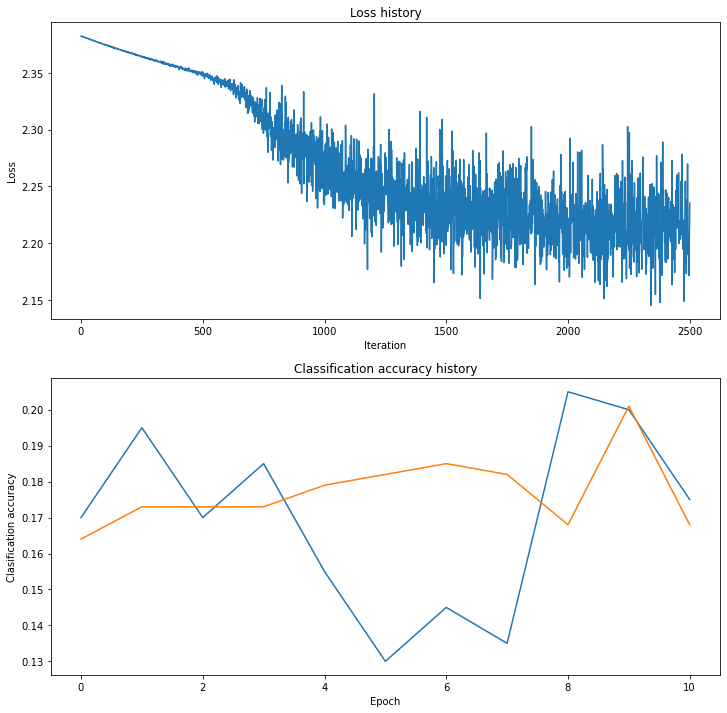

lr: 0.001, hidden_size: 50, regularization: 0
iteration 0 / 2500: loss 2.317391
iteration 100 / 2500: loss 2.229980
iteration 200 / 2500: loss 2.118781
iteration 300 / 2500: loss 1.950436
iteration 400 / 2500: loss 1.879536
iteration 500 / 2500: loss 1.880532
iteration 600 / 2500: loss 1.861420
iteration 700 / 2500: loss 1.849591
iteration 800 / 2500: loss 1.737385
iteration 900 / 2500: loss 1.675753
iteration 1000 / 2500: loss 1.702588
iteration 1100 / 2500: loss 1.679496
iteration 1200 / 2500: loss 1.765927
iteration 1300 / 2500: loss 1.678664
iteration 1400 / 2500: loss 1.722179
iteration 1500 / 2500: loss 1.556700
iteration 1600 / 2500: loss 1.673753
iteration 1700 / 2500: loss 1.602938
iteration 1800 / 2500: loss 1.596334
iteration 1900 / 2500: loss 1.528715
iteration 2000 / 2500: loss 1.629710
iteration 2100 / 2500: loss 1.569977
iteration 2200 / 2500: loss 1.581796
iteration 2300 / 2500: loss 1.369650
iteration 2400 / 2500: loss 1.555226




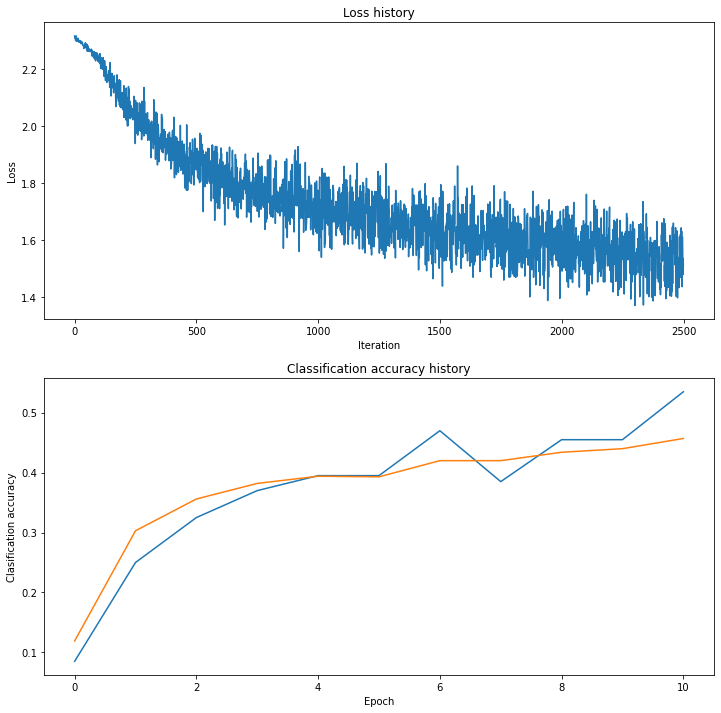

lr: 0.001, hidden_size: 50, regularization: 0.1
iteration 0 / 2500: loss 3.079248
iteration 100 / 2500: loss 3.008035
iteration 200 / 2500: loss 2.866841
iteration 300 / 2500: loss 2.727086
iteration 400 / 2500: loss 2.671890
iteration 500 / 2500: loss 2.719749
iteration 600 / 2500: loss 2.623458
iteration 700 / 2500: loss 2.391270
iteration 800 / 2500: loss 2.458979
iteration 900 / 2500: loss 2.500308
iteration 1000 / 2500: loss 2.410609
iteration 1100 / 2500: loss 2.376829
iteration 1200 / 2500: loss 2.336479
iteration 1300 / 2500: loss 2.420248
iteration 1400 / 2500: loss 2.233946
iteration 1500 / 2500: loss 2.243200
iteration 1600 / 2500: loss 2.224019
iteration 1700 / 2500: loss 2.135778
iteration 1800 / 2500: loss 2.168218
iteration 1900 / 2500: loss 2.112839
iteration 2000 / 2500: loss 2.169427
iteration 2100 / 2500: loss 2.188637
iteration 2200 / 2500: loss 2.034941
iteration 2300 / 2500: loss 2.067384
iteration 2400 / 2500: loss 1.881805




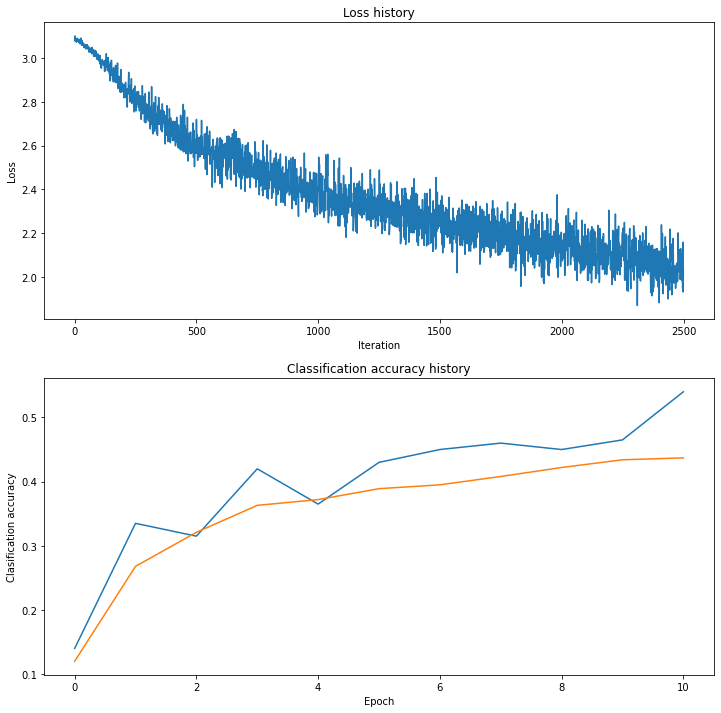

lr: 0.001, hidden_size: 50, regularization: 0.15
iteration 0 / 2500: loss 3.476905
iteration 100 / 2500: loss 3.391861
iteration 200 / 2500: loss 3.252135
iteration 300 / 2500: loss 3.028257
iteration 400 / 2500: loss 2.979181
iteration 500 / 2500: loss 2.929214
iteration 600 / 2500: loss 2.812340
iteration 700 / 2500: loss 2.821259
iteration 800 / 2500: loss 2.819807
iteration 900 / 2500: loss 2.702009
iteration 1000 / 2500: loss 2.585190
iteration 1100 / 2500: loss 2.641939
iteration 1200 / 2500: loss 2.562223
iteration 1300 / 2500: loss 2.491299
iteration 1400 / 2500: loss 2.556618
iteration 1500 / 2500: loss 2.391076
iteration 1600 / 2500: loss 2.324867
iteration 1700 / 2500: loss 2.417681
iteration 1800 / 2500: loss 2.294657
iteration 1900 / 2500: loss 2.320025
iteration 2000 / 2500: loss 2.339412
iteration 2100 / 2500: loss 2.358813
iteration 2200 / 2500: loss 2.281047
iteration 2300 / 2500: loss 2.284366
iteration 2400 / 2500: loss 2.114160




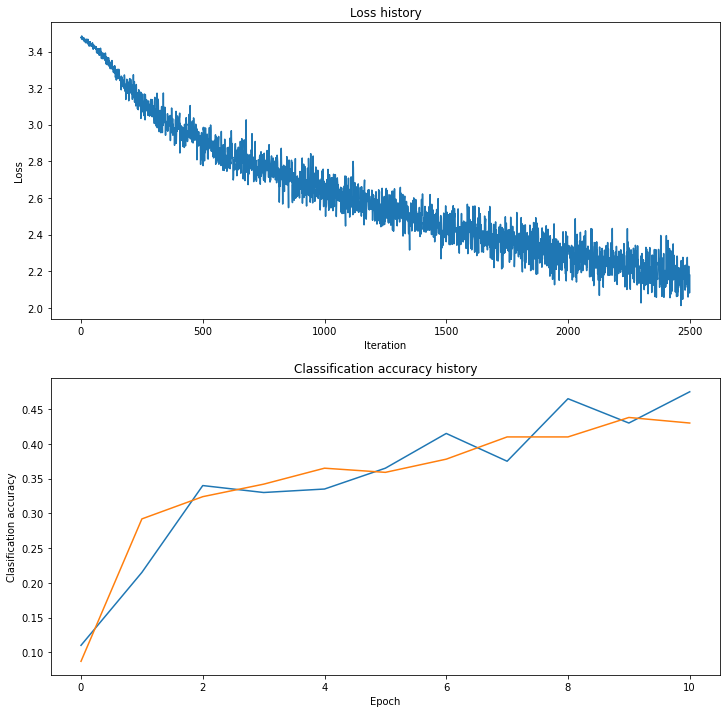

lr: 0.001, hidden_size: 50, regularization: 0.2
iteration 0 / 2500: loss 3.862661
iteration 100 / 2500: loss 3.686584
iteration 200 / 2500: loss 3.536786
iteration 300 / 2500: loss 3.419855
iteration 400 / 2500: loss 3.224369
iteration 500 / 2500: loss 3.214563
iteration 600 / 2500: loss 3.023146
iteration 700 / 2500: loss 2.979623
iteration 800 / 2500: loss 2.990412
iteration 900 / 2500: loss 2.939181
iteration 1000 / 2500: loss 2.910589
iteration 1100 / 2500: loss 2.874653
iteration 1200 / 2500: loss 2.759633
iteration 1300 / 2500: loss 2.558756
iteration 1400 / 2500: loss 2.664384
iteration 1500 / 2500: loss 2.508359
iteration 1600 / 2500: loss 2.532801
iteration 1700 / 2500: loss 2.519542
iteration 1800 / 2500: loss 2.539961
iteration 1900 / 2500: loss 2.326921
iteration 2000 / 2500: loss 2.363608
iteration 2100 / 2500: loss 2.425776
iteration 2200 / 2500: loss 2.161820
iteration 2300 / 2500: loss 2.323925
iteration 2400 / 2500: loss 2.318188




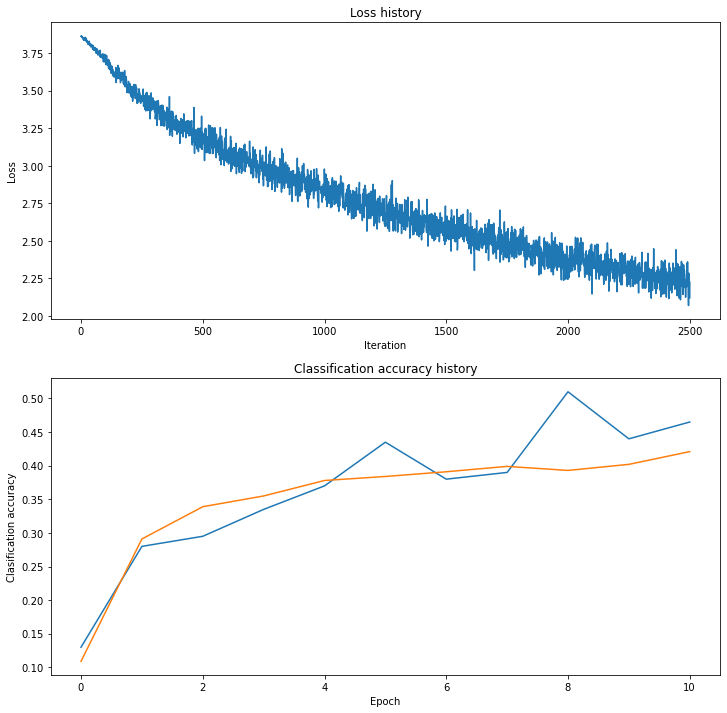

lr: 0.001, hidden_size: 50, regularization: 0.25
iteration 0 / 2500: loss 4.271333
iteration 100 / 2500: loss 4.118436
iteration 200 / 2500: loss 3.951936
iteration 300 / 2500: loss 3.720209
iteration 400 / 2500: loss 3.608876
iteration 500 / 2500: loss 3.454290
iteration 600 / 2500: loss 3.334436
iteration 700 / 2500: loss 3.293824
iteration 800 / 2500: loss 3.139446
iteration 900 / 2500: loss 3.013716
iteration 1000 / 2500: loss 3.019390
iteration 1100 / 2500: loss 2.950321
iteration 1200 / 2500: loss 2.790030
iteration 1300 / 2500: loss 2.809795
iteration 1400 / 2500: loss 2.763450
iteration 1500 / 2500: loss 2.662342
iteration 1600 / 2500: loss 2.622154
iteration 1700 / 2500: loss 2.567807
iteration 1800 / 2500: loss 2.435502
iteration 1900 / 2500: loss 2.469694
iteration 2000 / 2500: loss 2.459299
iteration 2100 / 2500: loss 2.304812
iteration 2200 / 2500: loss 2.356708
iteration 2300 / 2500: loss 2.407422
iteration 2400 / 2500: loss 2.280075




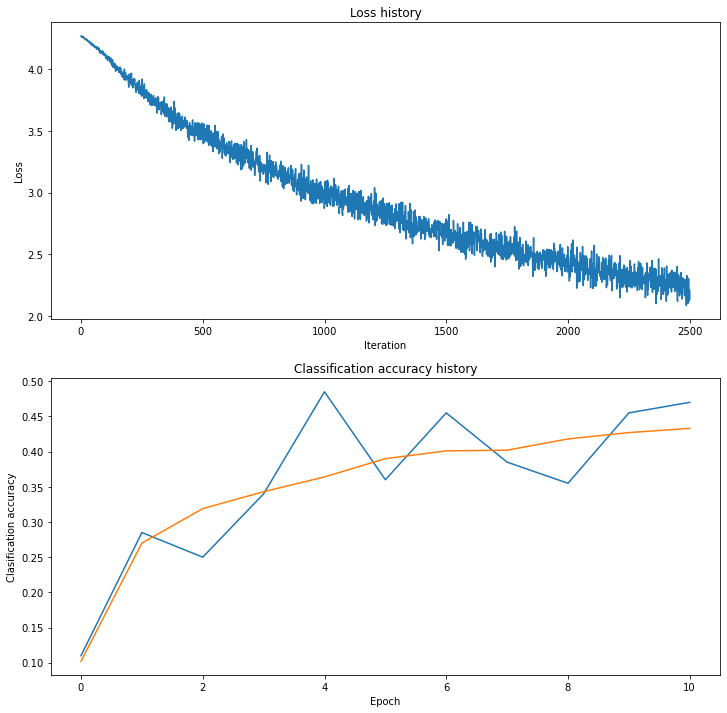

lr: 0.001, hidden_size: 50, regularization: 0.5
iteration 0 / 2500: loss 6.219581
iteration 100 / 2500: loss 5.765226
iteration 200 / 2500: loss 5.366855
iteration 300 / 2500: loss 4.939895
iteration 400 / 2500: loss 4.507553
iteration 500 / 2500: loss 4.289297
iteration 600 / 2500: loss 4.041699
iteration 700 / 2500: loss 3.742365
iteration 800 / 2500: loss 3.608690
iteration 900 / 2500: loss 3.409544
iteration 1000 / 2500: loss 3.343977
iteration 1100 / 2500: loss 3.142023
iteration 1200 / 2500: loss 3.013399
iteration 1300 / 2500: loss 2.956349
iteration 1400 / 2500: loss 2.744161
iteration 1500 / 2500: loss 2.663091
iteration 1600 / 2500: loss 2.623333
iteration 1700 / 2500: loss 2.504894
iteration 1800 / 2500: loss 2.561665
iteration 1900 / 2500: loss 2.399774
iteration 2000 / 2500: loss 2.319110
iteration 2100 / 2500: loss 2.287675
iteration 2200 / 2500: loss 2.249386
iteration 2300 / 2500: loss 2.243982
iteration 2400 / 2500: loss 2.178521




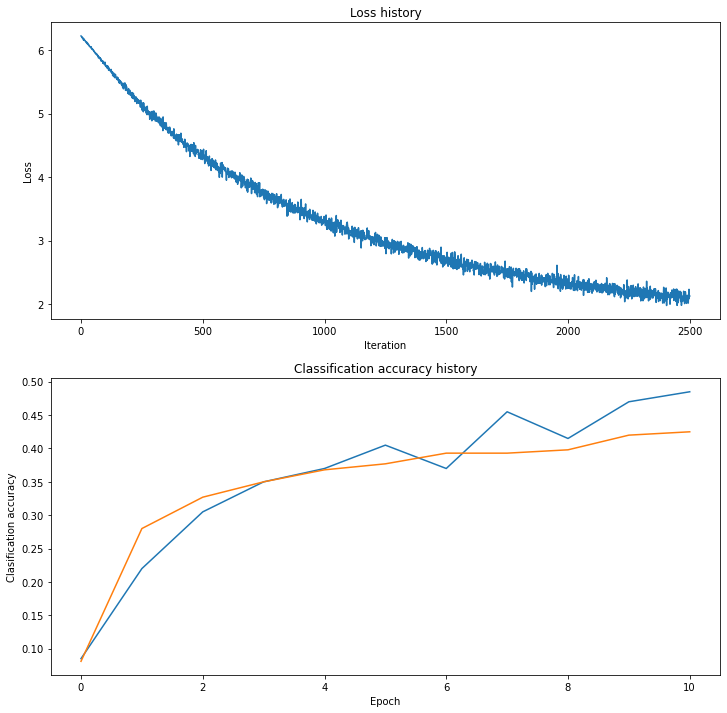

lr: 0.001, hidden_size: 100, regularization: 0
iteration 0 / 2500: loss 2.297980
iteration 100 / 2500: loss 2.121922
iteration 200 / 2500: loss 1.911571
iteration 300 / 2500: loss 1.863230
iteration 400 / 2500: loss 1.860447
iteration 500 / 2500: loss 1.835096
iteration 600 / 2500: loss 1.774320
iteration 700 / 2500: loss 1.632013
iteration 800 / 2500: loss 1.748585
iteration 900 / 2500: loss 1.629749
iteration 1000 / 2500: loss 1.593361
iteration 1100 / 2500: loss 1.671170
iteration 1200 / 2500: loss 1.473436
iteration 1300 / 2500: loss 1.604175
iteration 1400 / 2500: loss 1.686322
iteration 1500 / 2500: loss 1.550427
iteration 1600 / 2500: loss 1.544997
iteration 1700 / 2500: loss 1.624384
iteration 1800 / 2500: loss 1.469519
iteration 1900 / 2500: loss 1.486207
iteration 2000 / 2500: loss 1.536648
iteration 2100 / 2500: loss 1.474632
iteration 2200 / 2500: loss 1.446344
iteration 2300 / 2500: loss 1.542639
iteration 2400 / 2500: loss 1.399028




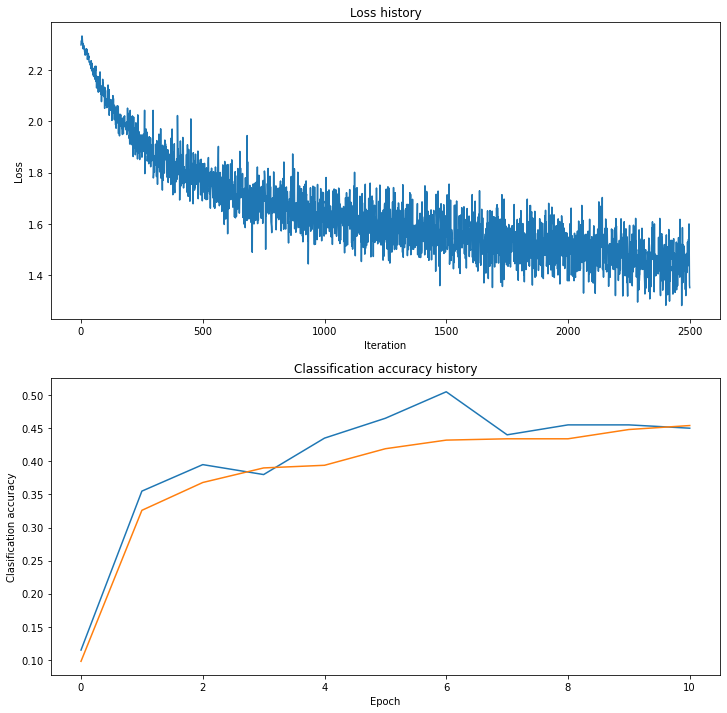

lr: 0.001, hidden_size: 100, regularization: 0.1
iteration 0 / 2500: loss 3.905935
iteration 100 / 2500: loss 3.584700
iteration 200 / 2500: loss 3.501494
iteration 300 / 2500: loss 3.412178
iteration 400 / 2500: loss 3.345196
iteration 500 / 2500: loss 3.196819
iteration 600 / 2500: loss 3.179911
iteration 700 / 2500: loss 3.104094
iteration 800 / 2500: loss 3.044421
iteration 900 / 2500: loss 3.035360
iteration 1000 / 2500: loss 2.901885
iteration 1100 / 2500: loss 2.824424
iteration 1200 / 2500: loss 2.854830
iteration 1300 / 2500: loss 2.885382
iteration 1400 / 2500: loss 2.806815
iteration 1500 / 2500: loss 2.759857
iteration 1600 / 2500: loss 2.703359
iteration 1700 / 2500: loss 2.829277
iteration 1800 / 2500: loss 2.824796
iteration 1900 / 2500: loss 2.724308
iteration 2000 / 2500: loss 2.595387
iteration 2100 / 2500: loss 2.709180
iteration 2200 / 2500: loss 2.647953
iteration 2300 / 2500: loss 2.497208
iteration 2400 / 2500: loss 2.482381




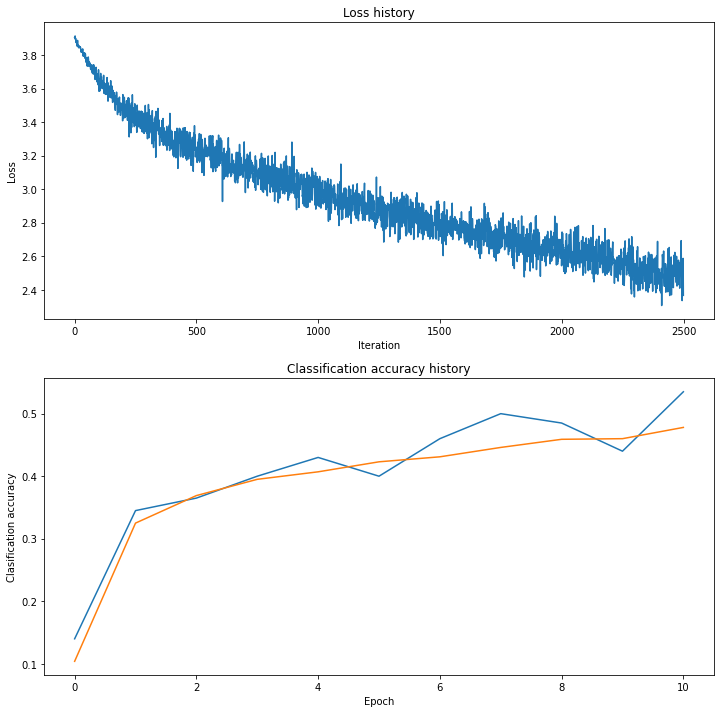

lr: 0.001, hidden_size: 100, regularization: 0.15
iteration 0 / 2500: loss 4.703026
iteration 100 / 2500: loss 4.437306
iteration 200 / 2500: loss 4.219354
iteration 300 / 2500: loss 4.045916
iteration 400 / 2500: loss 3.859548
iteration 500 / 2500: loss 3.822839
iteration 600 / 2500: loss 3.863078
iteration 700 / 2500: loss 3.732427
iteration 800 / 2500: loss 3.633690
iteration 900 / 2500: loss 3.547006
iteration 1000 / 2500: loss 3.570650
iteration 1100 / 2500: loss 3.498049
iteration 1200 / 2500: loss 3.282609
iteration 1300 / 2500: loss 3.290601
iteration 1400 / 2500: loss 3.148838
iteration 1500 / 2500: loss 3.156791
iteration 1600 / 2500: loss 3.037672
iteration 1700 / 2500: loss 2.994552
iteration 1800 / 2500: loss 2.952618
iteration 1900 / 2500: loss 3.004884
iteration 2000 / 2500: loss 2.874088
iteration 2100 / 2500: loss 2.734822
iteration 2200 / 2500: loss 2.941660
iteration 2300 / 2500: loss 2.782980
iteration 2400 / 2500: loss 2.672822




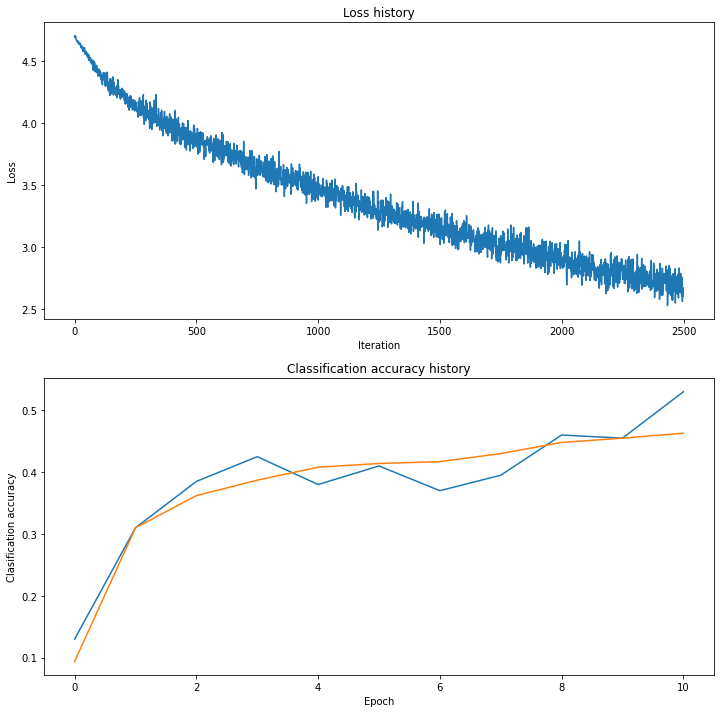

lr: 0.001, hidden_size: 100, regularization: 0.2
iteration 0 / 2500: loss 5.463893
iteration 100 / 2500: loss 5.131391
iteration 200 / 2500: loss 4.922202
iteration 300 / 2500: loss 4.730280
iteration 400 / 2500: loss 4.425691
iteration 500 / 2500: loss 4.404547
iteration 600 / 2500: loss 4.314545
iteration 700 / 2500: loss 4.173420
iteration 800 / 2500: loss 4.128837
iteration 900 / 2500: loss 3.968973
iteration 1000 / 2500: loss 3.708395
iteration 1100 / 2500: loss 3.879475
iteration 1200 / 2500: loss 3.648184
iteration 1300 / 2500: loss 3.691760
iteration 1400 / 2500: loss 3.508492
iteration 1500 / 2500: loss 3.470792
iteration 1600 / 2500: loss 3.345922
iteration 1700 / 2500: loss 3.215863
iteration 1800 / 2500: loss 3.049864
iteration 1900 / 2500: loss 3.265048
iteration 2000 / 2500: loss 3.095769
iteration 2100 / 2500: loss 2.935328
iteration 2200 / 2500: loss 2.842437
iteration 2300 / 2500: loss 2.727993
iteration 2400 / 2500: loss 2.739575




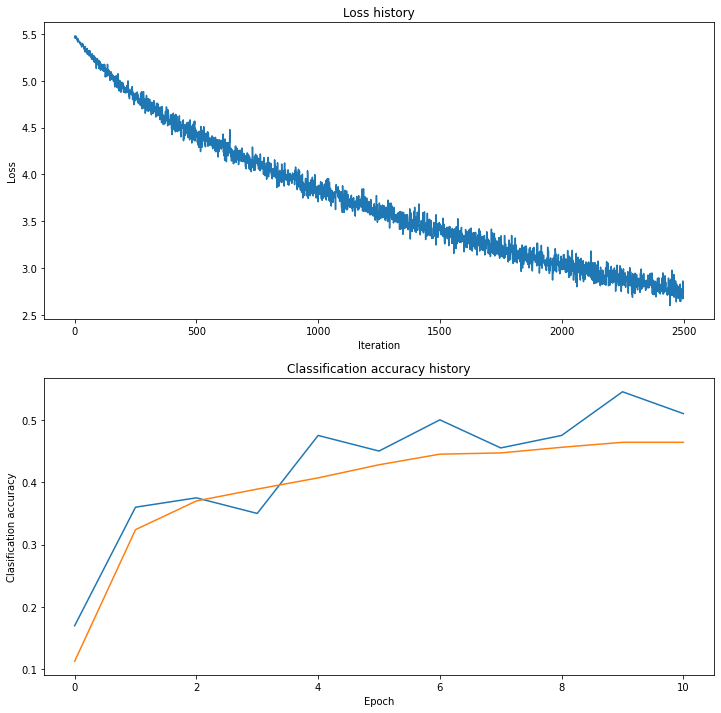

lr: 0.001, hidden_size: 100, regularization: 0.25
iteration 0 / 2500: loss 6.301117
iteration 100 / 2500: loss 5.908874
iteration 200 / 2500: loss 5.660424
iteration 300 / 2500: loss 5.319647
iteration 400 / 2500: loss 5.091863
iteration 500 / 2500: loss 4.949056
iteration 600 / 2500: loss 4.820790
iteration 700 / 2500: loss 4.619111
iteration 800 / 2500: loss 4.476227
iteration 900 / 2500: loss 4.324608
iteration 1000 / 2500: loss 4.093191
iteration 1100 / 2500: loss 4.127346
iteration 1200 / 2500: loss 3.738548
iteration 1300 / 2500: loss 3.833798
iteration 1400 / 2500: loss 3.678096
iteration 1500 / 2500: loss 3.643618
iteration 1600 / 2500: loss 3.466077
iteration 1700 / 2500: loss 3.331951
iteration 1800 / 2500: loss 3.373287
iteration 1900 / 2500: loss 3.165191
iteration 2000 / 2500: loss 3.142764
iteration 2100 / 2500: loss 3.118396
iteration 2200 / 2500: loss 2.820224
iteration 2300 / 2500: loss 2.892960
iteration 2400 / 2500: loss 2.804048




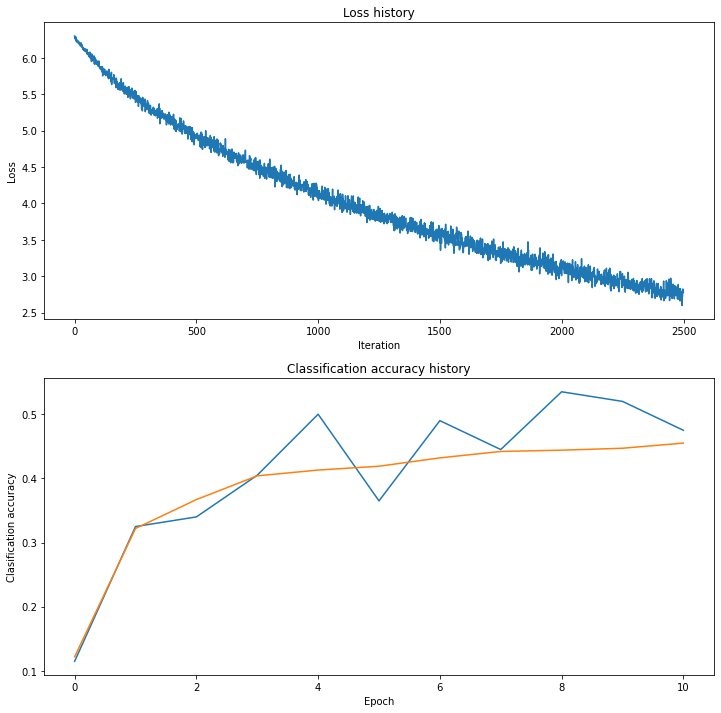

lr: 0.001, hidden_size: 100, regularization: 0.5
iteration 0 / 2500: loss 10.266720
iteration 100 / 2500: loss 9.308797
iteration 200 / 2500: loss 8.533806
iteration 300 / 2500: loss 7.839713
iteration 400 / 2500: loss 7.238821
iteration 500 / 2500: loss 6.646080
iteration 600 / 2500: loss 6.123621
iteration 700 / 2500: loss 5.751173
iteration 800 / 2500: loss 5.481815
iteration 900 / 2500: loss 4.968713
iteration 1000 / 2500: loss 4.770641
iteration 1100 / 2500: loss 4.499912
iteration 1200 / 2500: loss 4.302535
iteration 1300 / 2500: loss 4.028549
iteration 1400 / 2500: loss 3.835690
iteration 1500 / 2500: loss 3.532143
iteration 1600 / 2500: loss 3.353990
iteration 1700 / 2500: loss 3.253150
iteration 1800 / 2500: loss 3.068946
iteration 1900 / 2500: loss 2.944633
iteration 2000 / 2500: loss 2.834868
iteration 2100 / 2500: loss 2.670644
iteration 2200 / 2500: loss 2.615378
iteration 2300 / 2500: loss 2.563538
iteration 2400 / 2500: loss 2.461710




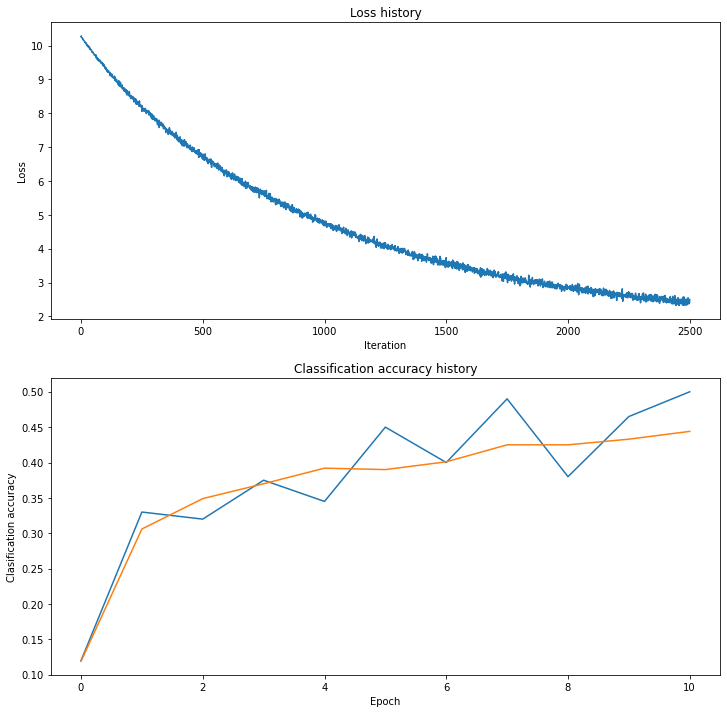

lr: 0.001, hidden_size: 200, regularization: 0
iteration 0 / 2500: loss 2.335196
iteration 100 / 2500: loss 1.973287
iteration 200 / 2500: loss 1.769383
iteration 300 / 2500: loss 1.721456
iteration 400 / 2500: loss 1.725646
iteration 500 / 2500: loss 1.638175
iteration 600 / 2500: loss 1.667098
iteration 700 / 2500: loss 1.616333
iteration 800 / 2500: loss 1.630058
iteration 900 / 2500: loss 1.520084
iteration 1000 / 2500: loss 1.590307
iteration 1100 / 2500: loss 1.584653
iteration 1200 / 2500: loss 1.561456
iteration 1300 / 2500: loss 1.438419
iteration 1400 / 2500: loss 1.473378
iteration 1500 / 2500: loss 1.333877
iteration 1600 / 2500: loss 1.520750
iteration 1700 / 2500: loss 1.469622
iteration 1800 / 2500: loss 1.457489
iteration 1900 / 2500: loss 1.485726
iteration 2000 / 2500: loss 1.363284
iteration 2100 / 2500: loss 1.446711
iteration 2200 / 2500: loss 1.380091
iteration 2300 / 2500: loss 1.294818
iteration 2400 / 2500: loss 1.504087




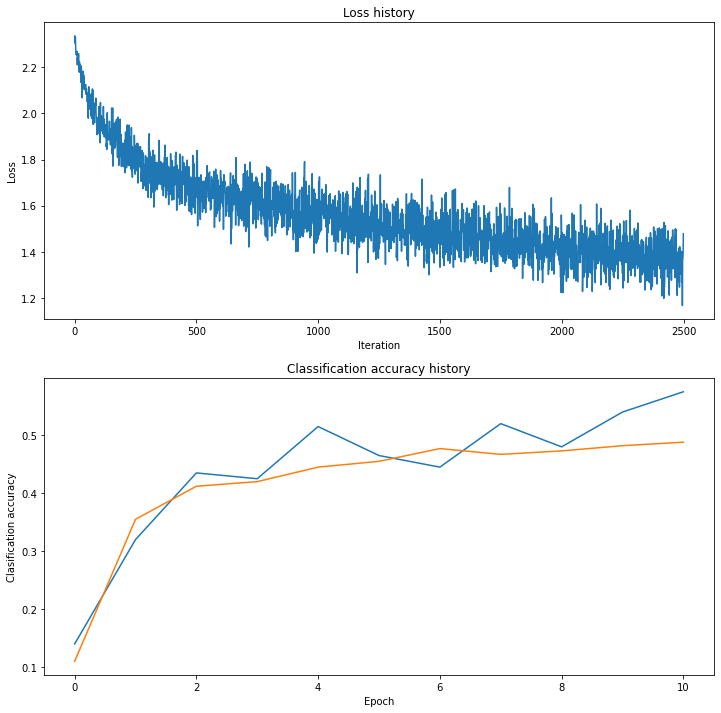

lr: 0.001, hidden_size: 200, regularization: 0.1
iteration 0 / 2500: loss 5.759748
iteration 100 / 2500: loss 5.245516
iteration 200 / 2500: loss 4.966143
iteration 300 / 2500: loss 4.856344
iteration 400 / 2500: loss 4.834283
iteration 500 / 2500: loss 4.722923
iteration 600 / 2500: loss 4.618476
iteration 700 / 2500: loss 4.534869
iteration 800 / 2500: loss 4.569697
iteration 900 / 2500: loss 4.413390
iteration 1000 / 2500: loss 4.468983
iteration 1100 / 2500: loss 4.267514
iteration 1200 / 2500: loss 4.339977
iteration 1300 / 2500: loss 4.007846
iteration 1400 / 2500: loss 4.127909
iteration 1500 / 2500: loss 4.039253
iteration 1600 / 2500: loss 3.986155
iteration 1700 / 2500: loss 3.850260
iteration 1800 / 2500: loss 3.706348
iteration 1900 / 2500: loss 3.836265
iteration 2000 / 2500: loss 3.659735
iteration 2100 / 2500: loss 3.727513
iteration 2200 / 2500: loss 3.624656
iteration 2300 / 2500: loss 3.568134
iteration 2400 / 2500: loss 3.378031




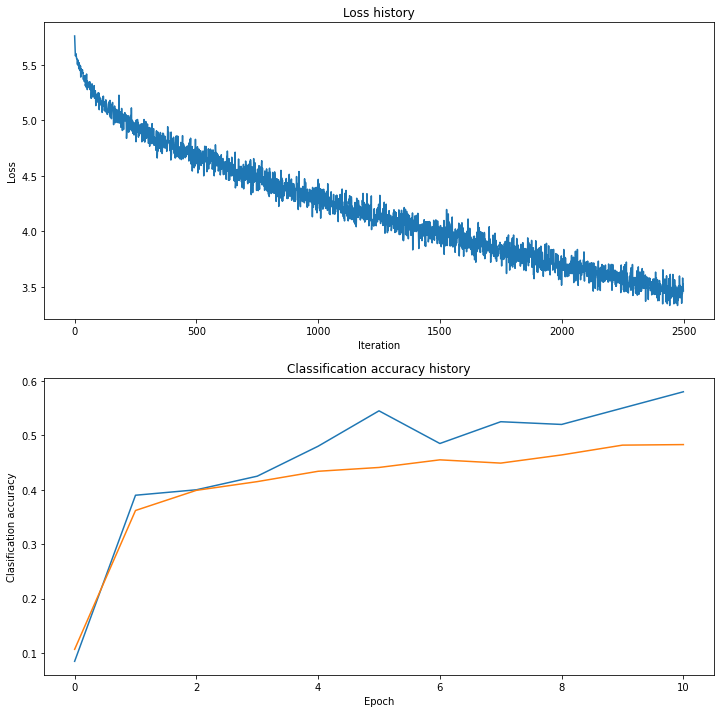

lr: 0.001, hidden_size: 200, regularization: 0.15
iteration 0 / 2500: loss 7.252269
iteration 100 / 2500: loss 6.722575
iteration 200 / 2500: loss 6.434728
iteration 300 / 2500: loss 6.367154
iteration 400 / 2500: loss 6.082146
iteration 500 / 2500: loss 5.957805
iteration 600 / 2500: loss 5.872667
iteration 700 / 2500: loss 5.605084
iteration 800 / 2500: loss 5.526426
iteration 900 / 2500: loss 5.542751
iteration 1000 / 2500: loss 5.179352
iteration 1100 / 2500: loss 5.212909
iteration 1200 / 2500: loss 5.083954
iteration 1300 / 2500: loss 4.983459
iteration 1400 / 2500: loss 4.806437
iteration 1500 / 2500: loss 4.689611
iteration 1600 / 2500: loss 4.658588
iteration 1700 / 2500: loss 4.422515
iteration 1800 / 2500: loss 4.296698
iteration 1900 / 2500: loss 4.319762
iteration 2000 / 2500: loss 4.118812
iteration 2100 / 2500: loss 4.149983
iteration 2200 / 2500: loss 4.027108
iteration 2300 / 2500: loss 3.917127
iteration 2400 / 2500: loss 3.904569




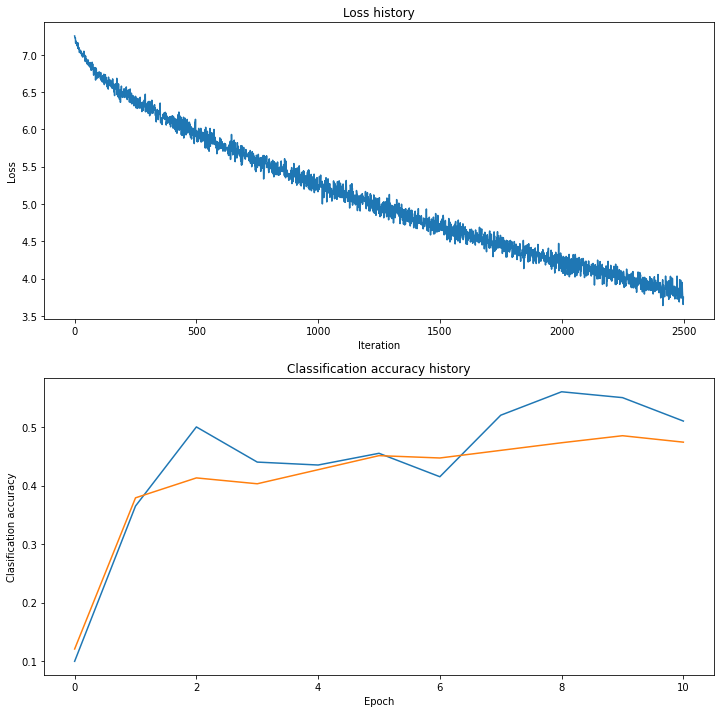

lr: 0.001, hidden_size: 200, regularization: 0.2
iteration 0 / 2500: loss 8.908310
iteration 100 / 2500: loss 8.231126
iteration 200 / 2500: loss 7.877983
iteration 300 / 2500: loss 7.665140
iteration 400 / 2500: loss 7.344668
iteration 500 / 2500: loss 6.994125
iteration 600 / 2500: loss 6.778416
iteration 700 / 2500: loss 6.651423
iteration 800 / 2500: loss 6.516083
iteration 900 / 2500: loss 6.164325
iteration 1000 / 2500: loss 5.996679
iteration 1100 / 2500: loss 5.913741
iteration 1200 / 2500: loss 5.615457
iteration 1300 / 2500: loss 5.453818
iteration 1400 / 2500: loss 5.238794
iteration 1500 / 2500: loss 5.100613
iteration 1600 / 2500: loss 5.153333
iteration 1700 / 2500: loss 4.969036
iteration 1800 / 2500: loss 4.824474
iteration 1900 / 2500: loss 4.652770
iteration 2000 / 2500: loss 4.511738
iteration 2100 / 2500: loss 4.286974
iteration 2200 / 2500: loss 4.341287
iteration 2300 / 2500: loss 4.164377
iteration 2400 / 2500: loss 4.069167




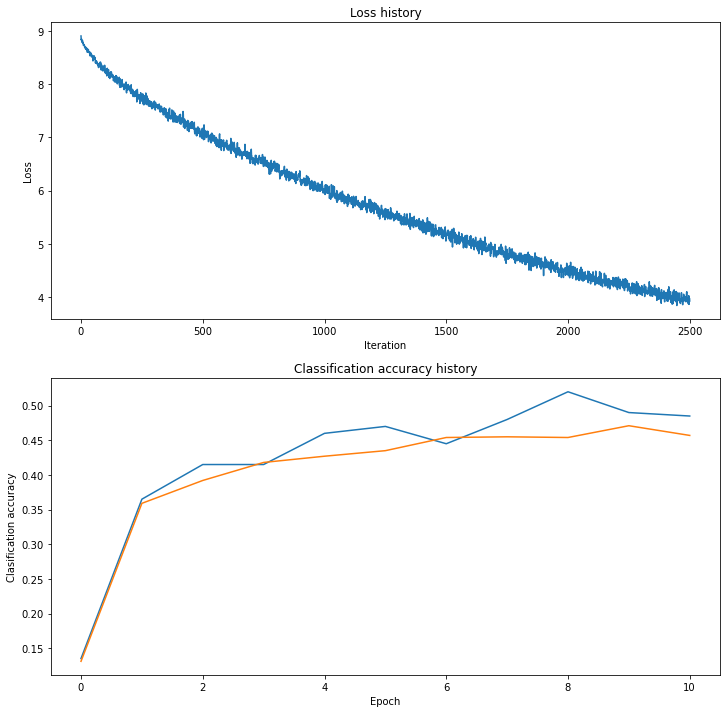

lr: 0.001, hidden_size: 200, regularization: 0.25
iteration 0 / 2500: loss 10.560930
iteration 100 / 2500: loss 9.833903
iteration 200 / 2500: loss 9.255980
iteration 300 / 2500: loss 8.877955
iteration 400 / 2500: loss 8.508051
iteration 500 / 2500: loss 8.116786
iteration 600 / 2500: loss 7.859714
iteration 700 / 2500: loss 7.449201
iteration 800 / 2500: loss 7.211005
iteration 900 / 2500: loss 6.923581
iteration 1000 / 2500: loss 6.612878
iteration 1100 / 2500: loss 6.422869
iteration 1200 / 2500: loss 6.277073
iteration 1300 / 2500: loss 5.898069
iteration 1400 / 2500: loss 5.788001
iteration 1500 / 2500: loss 5.420662
iteration 1600 / 2500: loss 5.257327
iteration 1700 / 2500: loss 5.075763
iteration 1800 / 2500: loss 4.943461
iteration 1900 / 2500: loss 4.785343
iteration 2000 / 2500: loss 4.571072
iteration 2100 / 2500: loss 4.478551
iteration 2200 / 2500: loss 4.261701
iteration 2300 / 2500: loss 4.268047
iteration 2400 / 2500: loss 4.101666




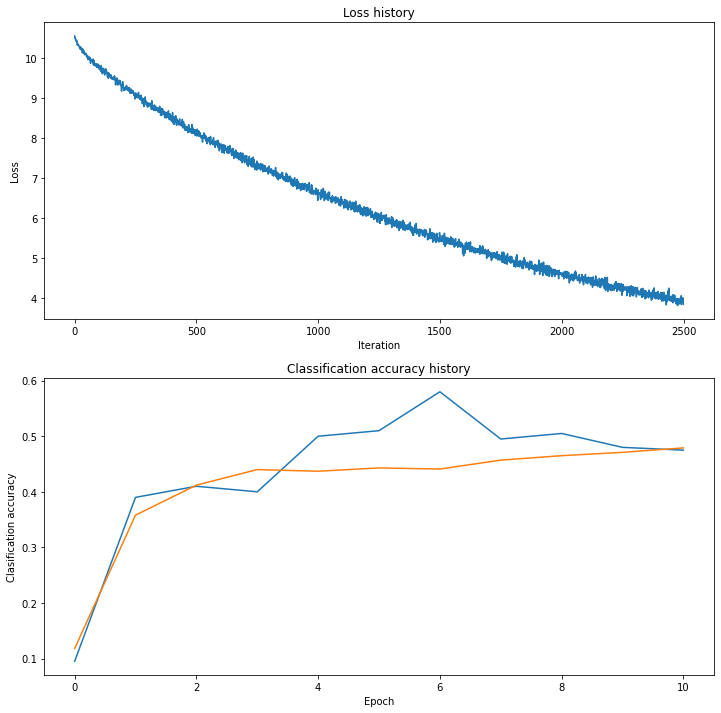

lr: 0.001, hidden_size: 200, regularization: 0.5
iteration 0 / 2500: loss 18.799198
iteration 100 / 2500: loss 16.863966
iteration 200 / 2500: loss 15.340227
iteration 300 / 2500: loss 13.961491
iteration 400 / 2500: loss 12.788369
iteration 500 / 2500: loss 11.755749
iteration 600 / 2500: loss 10.813032
iteration 700 / 2500: loss 9.975486
iteration 800 / 2500: loss 9.160327
iteration 900 / 2500: loss 8.448726
iteration 1000 / 2500: loss 7.762339
iteration 1100 / 2500: loss 7.188264
iteration 1200 / 2500: loss 6.706393
iteration 1300 / 2500: loss 6.227156
iteration 1400 / 2500: loss 5.850029
iteration 1500 / 2500: loss 5.365869
iteration 1600 / 2500: loss 5.069500
iteration 1700 / 2500: loss 4.678288
iteration 1800 / 2500: loss 4.436353
iteration 1900 / 2500: loss 4.137905
iteration 2000 / 2500: loss 3.875916
iteration 2100 / 2500: loss 3.813209
iteration 2200 / 2500: loss 3.578849
iteration 2300 / 2500: loss 3.439801
iteration 2400 / 2500: loss 3.252735




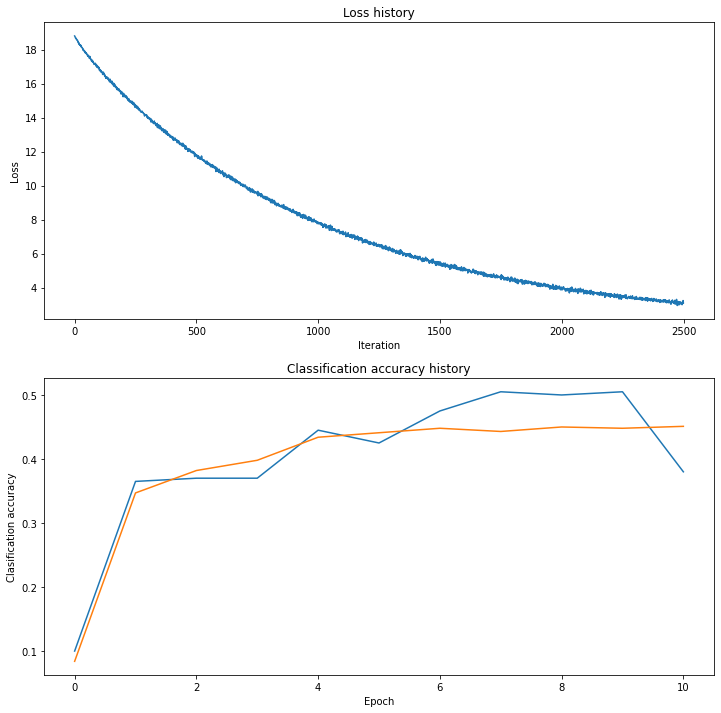

lr: 0.001, hidden_size: 500, regularization: 0
iteration 0 / 2500: loss 2.579011
iteration 100 / 2500: loss 1.911640
iteration 200 / 2500: loss 1.661135
iteration 300 / 2500: loss 1.821503
iteration 400 / 2500: loss 1.685161
iteration 500 / 2500: loss 1.486977
iteration 600 / 2500: loss 1.589375
iteration 700 / 2500: loss 1.605123
iteration 800 / 2500: loss 1.364227
iteration 900 / 2500: loss 1.500871
iteration 1000 / 2500: loss 1.601969
iteration 1100 / 2500: loss 1.400256
iteration 1200 / 2500: loss 1.411973
iteration 1300 / 2500: loss 1.458407
iteration 1400 / 2500: loss 1.523934
iteration 1500 / 2500: loss 1.224175
iteration 1600 / 2500: loss 1.244058
iteration 1700 / 2500: loss 1.282915
iteration 1800 / 2500: loss 1.388389
iteration 1900 / 2500: loss 1.222294
iteration 2000 / 2500: loss 1.282970
iteration 2100 / 2500: loss 1.256405
iteration 2200 / 2500: loss 1.050397
iteration 2300 / 2500: loss 1.224823
iteration 2400 / 2500: loss 1.076073




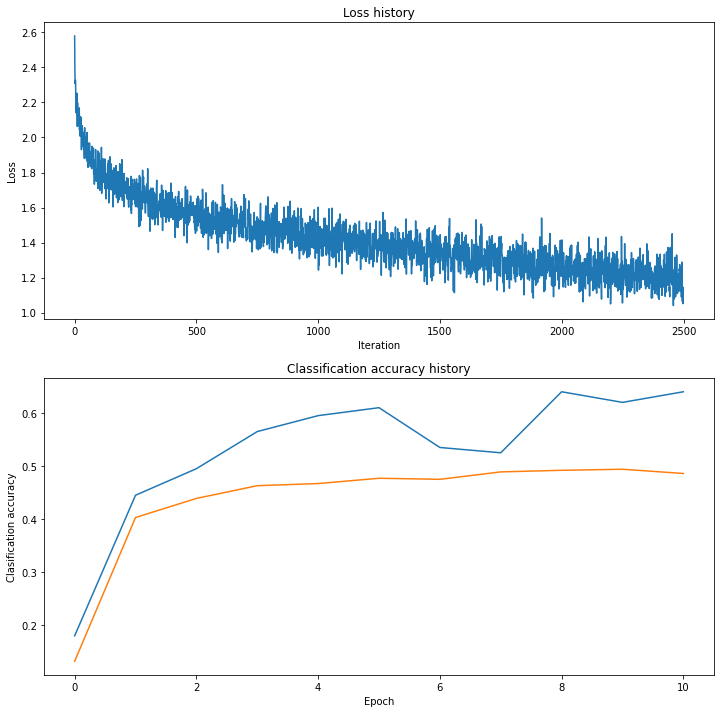

lr: 0.001, hidden_size: 500, regularization: 0.1
iteration 0 / 2500: loss 11.643774
iteration 100 / 2500: loss 10.580658
iteration 200 / 2500: loss 10.320796
iteration 300 / 2500: loss 10.071390
iteration 400 / 2500: loss 9.810375
iteration 500 / 2500: loss 9.668976
iteration 600 / 2500: loss 9.459590
iteration 700 / 2500: loss 9.313927
iteration 800 / 2500: loss 9.152084
iteration 900 / 2500: loss 8.875939
iteration 1000 / 2500: loss 8.734419
iteration 1100 / 2500: loss 8.498248
iteration 1200 / 2500: loss 8.452805
iteration 1300 / 2500: loss 8.386230
iteration 1400 / 2500: loss 8.208084
iteration 1500 / 2500: loss 8.017664
iteration 1600 / 2500: loss 7.911841
iteration 1700 / 2500: loss 7.745946
iteration 1800 / 2500: loss 7.782014
iteration 1900 / 2500: loss 7.545386
iteration 2000 / 2500: loss 7.444693
iteration 2100 / 2500: loss 7.310603
iteration 2200 / 2500: loss 7.142862
iteration 2300 / 2500: loss 6.918884
iteration 2400 / 2500: loss 6.926747




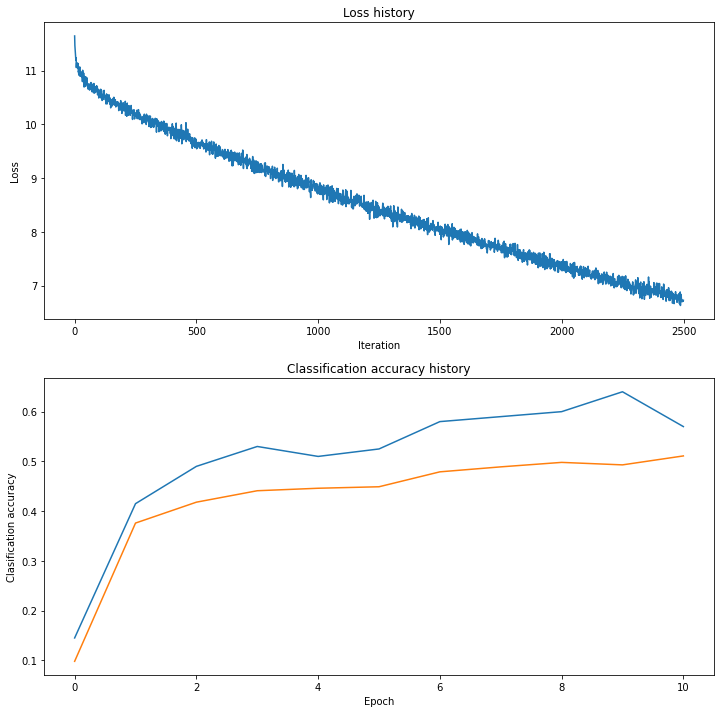

lr: 0.001, hidden_size: 500, regularization: 0.15
iteration 0 / 2500: loss 15.921809
iteration 100 / 2500: loss 14.796421
iteration 200 / 2500: loss 14.284018
iteration 300 / 2500: loss 14.003452
iteration 400 / 2500: loss 13.576923
iteration 500 / 2500: loss 13.128759
iteration 600 / 2500: loss 12.853676
iteration 700 / 2500: loss 12.464964
iteration 800 / 2500: loss 12.007909
iteration 900 / 2500: loss 11.731708
iteration 1000 / 2500: loss 11.374059
iteration 1100 / 2500: loss 11.101417
iteration 1200 / 2500: loss 10.897835
iteration 1300 / 2500: loss 10.654826
iteration 1400 / 2500: loss 10.309435
iteration 1500 / 2500: loss 10.100698
iteration 1600 / 2500: loss 9.666499
iteration 1700 / 2500: loss 9.556688
iteration 1800 / 2500: loss 9.193679
iteration 1900 / 2500: loss 9.031587
iteration 2000 / 2500: loss 8.853894
iteration 2100 / 2500: loss 8.606927
iteration 2200 / 2500: loss 8.426125
iteration 2300 / 2500: loss 8.090470
iteration 2400 / 2500: loss 7.854459




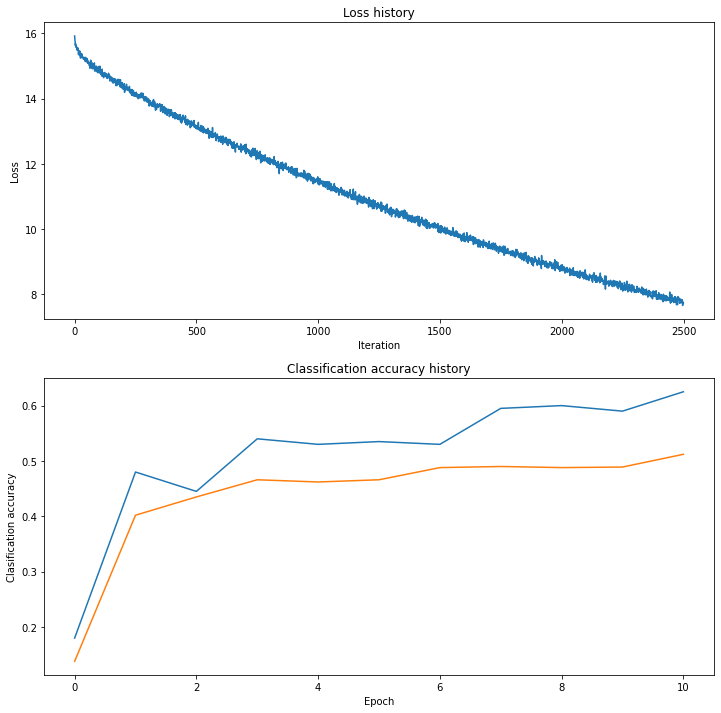

lr: 0.001, hidden_size: 500, regularization: 0.2
iteration 0 / 2500: loss 20.565444
iteration 100 / 2500: loss 19.007652
iteration 200 / 2500: loss 18.307329
iteration 300 / 2500: loss 17.686252
iteration 400 / 2500: loss 16.855018
iteration 500 / 2500: loss 16.441359
iteration 600 / 2500: loss 15.726635
iteration 700 / 2500: loss 15.062285
iteration 800 / 2500: loss 14.543998
iteration 900 / 2500: loss 14.047754
iteration 1000 / 2500: loss 13.450387
iteration 1100 / 2500: loss 12.963114
iteration 1200 / 2500: loss 12.622052
iteration 1300 / 2500: loss 12.247998
iteration 1400 / 2500: loss 11.594764
iteration 1500 / 2500: loss 11.342784
iteration 1600 / 2500: loss 10.783337
iteration 1700 / 2500: loss 10.603126
iteration 1800 / 2500: loss 10.263168
iteration 1900 / 2500: loss 9.762359
iteration 2000 / 2500: loss 9.589389
iteration 2100 / 2500: loss 9.164930
iteration 2200 / 2500: loss 8.854075
iteration 2300 / 2500: loss 8.560879
iteration 2400 / 2500: loss 8.334351




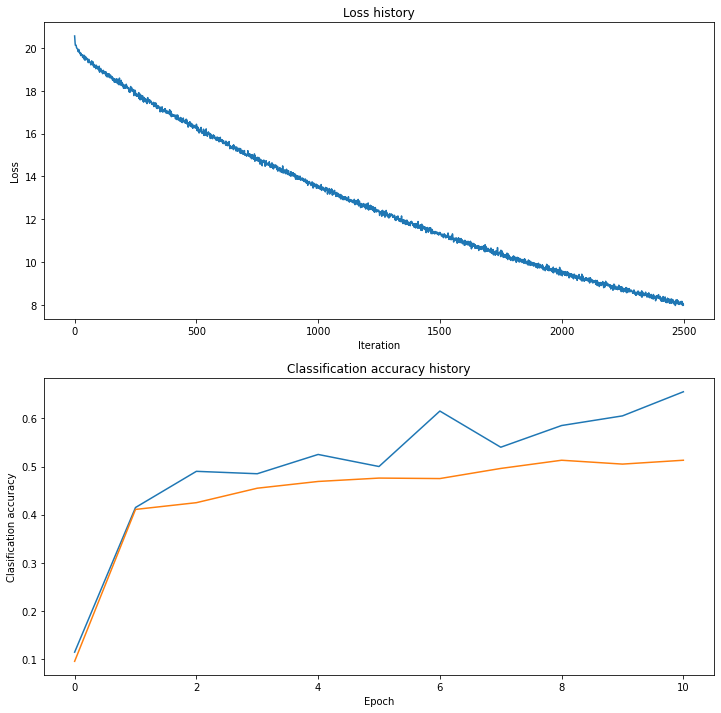

lr: 0.001, hidden_size: 500, regularization: 0.25
iteration 0 / 2500: loss 24.964006
iteration 100 / 2500: loss 23.064836
iteration 200 / 2500: loss 21.966005
iteration 300 / 2500: loss 20.888995
iteration 400 / 2500: loss 20.014446
iteration 500 / 2500: loss 19.017361
iteration 600 / 2500: loss 18.126276
iteration 700 / 2500: loss 17.293062
iteration 800 / 2500: loss 16.582676
iteration 900 / 2500: loss 15.970989
iteration 1000 / 2500: loss 15.120791
iteration 1100 / 2500: loss 14.400445
iteration 1200 / 2500: loss 13.604640
iteration 1300 / 2500: loss 13.242664
iteration 1400 / 2500: loss 12.676017
iteration 1500 / 2500: loss 12.115619
iteration 1600 / 2500: loss 11.604298
iteration 1700 / 2500: loss 11.134057
iteration 1800 / 2500: loss 10.575957
iteration 1900 / 2500: loss 10.166403
iteration 2000 / 2500: loss 9.762047
iteration 2100 / 2500: loss 9.284165
iteration 2200 / 2500: loss 8.955365
iteration 2300 / 2500: loss 8.452627
iteration 2400 / 2500: loss 8.257775




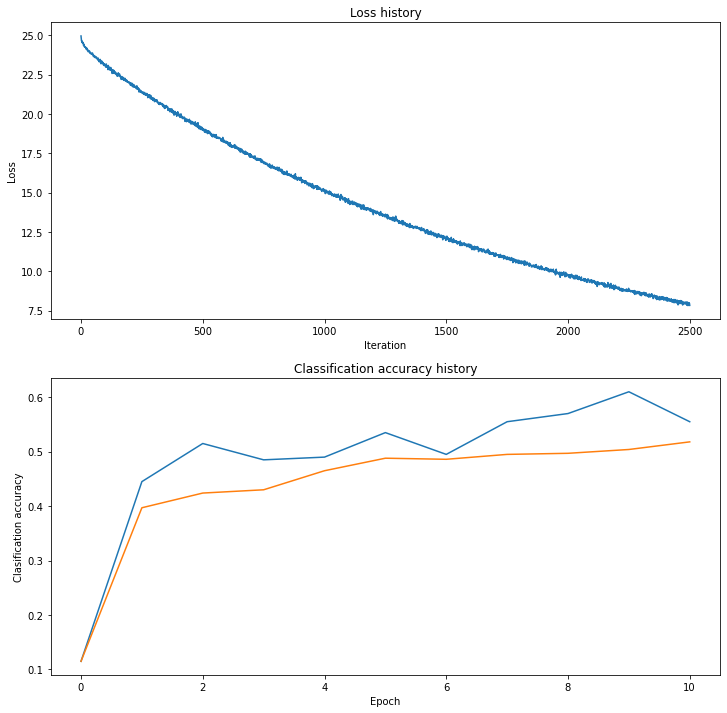

lr: 0.001, hidden_size: 500, regularization: 0.5
iteration 0 / 2500: loss 47.488744
iteration 100 / 2500: loss 42.251920
iteration 200 / 2500: loss 38.439392
iteration 300 / 2500: loss 34.760961
iteration 400 / 2500: loss 31.607420
iteration 500 / 2500: loss 28.753751
iteration 600 / 2500: loss 26.250360
iteration 700 / 2500: loss 23.922194
iteration 800 / 2500: loss 21.822544
iteration 900 / 2500: loss 19.809151
iteration 1000 / 2500: loss 18.143652
iteration 1100 / 2500: loss 16.711906
iteration 1200 / 2500: loss 15.250443
iteration 1300 / 2500: loss 13.888822
iteration 1400 / 2500: loss 12.726445
iteration 1500 / 2500: loss 11.584003
iteration 1600 / 2500: loss 10.707180
iteration 1700 / 2500: loss 9.927486
iteration 1800 / 2500: loss 9.040551
iteration 1900 / 2500: loss 8.419161
iteration 2000 / 2500: loss 7.738089
iteration 2100 / 2500: loss 7.138305
iteration 2200 / 2500: loss 6.725224
iteration 2300 / 2500: loss 6.282782
iteration 2400 / 2500: loss 5.669308




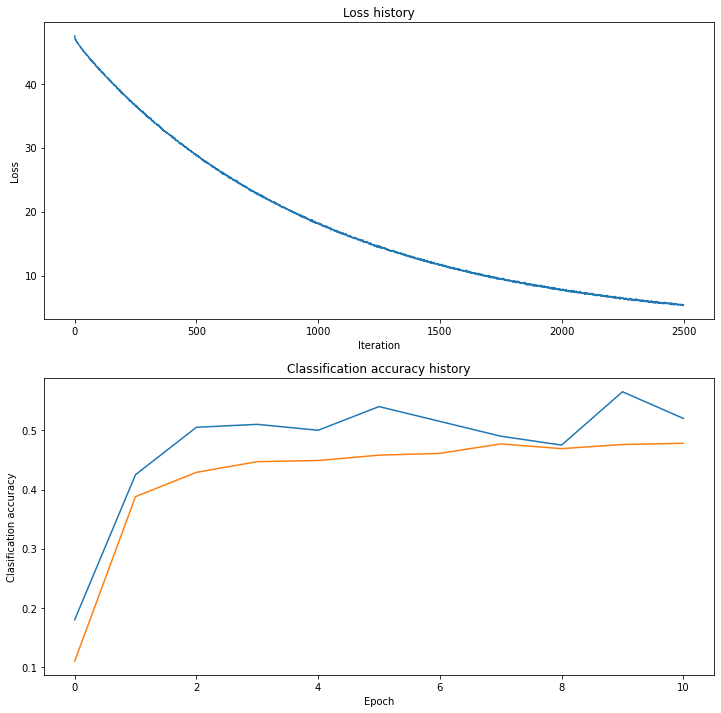

lr 1.000000e-07 hidden_size 200.000000 reg 0.000000 train accuracy: 0.105449 val accuracy: 0.108000
lr 1.000000e-03 hidden_size 1.000000 reg 0.000000 train accuracy: 0.181673 val accuracy: 0.198000
lr 1.000000e-03 hidden_size 1.000000 reg 0.100000 train accuracy: 0.176959 val accuracy: 0.196000
lr 1.000000e-03 hidden_size 1.000000 reg 0.150000 train accuracy: 0.099959 val accuracy: 0.112000
lr 1.000000e-03 hidden_size 1.000000 reg 0.200000 train accuracy: 0.100265 val accuracy: 0.103000
lr 1.000000e-03 hidden_size 1.000000 reg 0.250000 train accuracy: 0.100449 val accuracy: 0.090000
lr 1.000000e-03 hidden_size 1.000000 reg 0.500000 train accuracy: 0.172673 val accuracy: 0.179000
lr 1.000000e-03 hidden_size 50.000000 reg 0.000000 train accuracy: 0.456612 val accuracy: 0.454000
lr 1.000000e-03 hidden_size 50.000000 reg 0.100000 train accuracy: 0.456327 val accuracy: 0.439000
lr 1.000000e-03 hidden_size 50.000000 reg 0.150000 train accuracy: 0.453714 val accuracy: 0.433000
lr 1.000000e-03

In [25]:
# You are encouraged to experiment with additional values
learning_rates = [1e-3] # this time its up to you
hidden_sizes = [1, 50, 100, 200, 500] # this time its up to you
regularizations = [0, 0.1, 0.15, 0.2, 0.25, 0.5] # this time its up to you

results = {}
best_val = -1   
best_net = None 
################################################################################
#                            START OF YOUR CODE                                #
################################################################################

results[(1e-7, 200, 0)] = (0,0,0)
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for regularization in regularizations:
            results[(lr, hidden_size, regularization)] = (0,0,0)
        
for (lr, hidden_size, regularization) in results.keys():
    print(f'lr: {lr}, hidden_size: {hidden_size}, regularization: {regularization}')
    model = ThreeLayerNet(input_size, hidden_size, num_classes)
    stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=2500, batch_size=200,
            learning_rate=lr, reg=regularization, verbose=True)
    
    val_acc = (model.predict(X_val) == y_val).mean()
    train_acc = (model.predict(X_train) == y_train).mean()

    results[(lr, hidden_size, regularization)] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_net = model
    print("\n")

    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = (best_net.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

## **Question:**
What can you say about the training? Why does it take much longer to train? How could you speed up computation? What would happen to the network accuracy and training time when adding additional layer? What about additional hidden neurons? **(5 Points)**

**Your answer:** *The modle's accuracy has improved. Lets investigate the effect of the each variable separately:*

*Learning rate: With lr=1e-7 the network isn't manage to learn within the 2500 epochs, where with lr=1e-3 the network learns well and getting to around 50% accuracy*

*Regularization coefficient: as the reg coefficient increase the training accuracy decrease, while the val accuracy initially increase, but if we'll increase that coefficent too much the val accuracy would start to decrease, which aligned with the class theoretical matrial. As we learned, L2 regularization intended to reduce the generalization error, but not its training error, but if the reg coefficient is too large the optimum value for the parameter vector w (w*) will move further towards the direction of central axis of the weight space, which might comes with some accuaracy expense.*

*Num. of hidden size: increasing the num of hidden size from 100 to 200, increase val accuracy. Increasing hidden size too much might leads to overfit, which in result decrease the val accuracy, and too small hidden size might lead to underfit*

*Since we increased the num of hidden size from 50 to 100 or 200, the model becomes more complex, which leads to longer time to train.*

*We could spped up computation by using concurrency and by running the different combinatation in parallel, by initializaing better hyperparameters and running on less iterations, by not using more hidden neurons and layers than needed or by using pytorch with GPU for the NN calculations and computation.*

*Adding additional layer or extra hidden neurons will increase training time, and initally it might improve the training and val accuracy, but if the model will start to overfit the training accuracy will keep increasing but the val accuracy would decrease.*

# The End